In [1]:
# train_frcnn_on_dataset.py
import os, json, glob, time
from typing import List, Tuple
from PIL import Image

import torch
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import box_iou
import matplotlib.pyplot as plt

In [6]:
# =========================
# 데이터셋
# =========================
def quad_to_xyxy(xs, ys):
    x1, y1 = min(xs), min(ys)
    x2, y2 = max(xs), max(ys)
    return float(x1), float(y1), float(x2), float(y2)

class CharDetDataset(Dataset):
    """
    dataset/
      train_image/*.{png|jpg|jpeg|bmp|tif|tiff}
      train_label/*.json
      valid_image/*.*
      valid_label/*.json
    """
    def __init__(self, root: str, split: str):
        assert split in ("train","valid")
        self.img_dir = os.path.join(root, f"{split}_image")
        self.lbl_dir = os.path.join(root, f"{split}_label")

        imgs: List[str] = []
        for ext in ("*.png","*.jpg","*.jpeg","*.bmp","*.tif","*.tiff"):
            imgs += glob.glob(os.path.join(self.img_dir, ext))
        imgs = sorted(imgs)

        pairs = []
        for ip in imgs:
            stem = os.path.splitext(os.path.basename(ip))[0]
            jp = os.path.join(self.lbl_dir, stem + ".json")
            if os.path.isfile(jp):
                pairs.append((ip, jp))

        if not pairs:
            raise RuntimeError("남는 (이미지,라벨) 쌍이 없습니다. 경로/확장자/파일명을 확인하세요.")

        self.pairs = pairs
        self.tf = T.ToTensor()
        print(f"[{split}] 사용 {len(self.pairs)}개")

    def __len__(self): 
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, json_path = self.pairs[idx]
        img = Image.open(img_path).convert("RGB")
        W, H = img.size

        with open(json_path, "r", encoding="utf-8") as f:
            meta = json.load(f)

        boxes, labels = [], []
        for it in meta.get("bbox", []):
            xs, ys = it.get("x"), it.get("y")
            if not xs or not ys: 
                continue
            x1,y1,x2,y2 = quad_to_xyxy(xs, ys)
            # 이미지 경계 클램프 + 유효성 체크
            x1 = max(0.0, min(x1, W-1))
            y1 = max(0.0, min(y1, H-1))
            x2 = max(0.0, min(x2, W-1))
            y2 = max(0.0, min(y2, H-1))
            if x2 > x1 and y2 > y1:
                boxes.append([x1,y1,x2,y2])
                labels.append(1)  # 단일 클래스(문자)

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
            "image_id": torch.tensor([idx]),
        }
        return self.tf(img), target, img_path

def collate(batch):
    imgs, tgs, paths = zip(*batch)
    return list(imgs), list(tgs), list(paths)

In [7]:
# =========================
# 모델
# =========================
def build_model(num_classes: int = 2):
    m = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(
        weights="DEFAULT", weights_backbone="DEFAULT"
    )
    in_feat = m.roi_heads.box_predictor.cls_score.in_features
    m.roi_heads.box_predictor = FastRCNNPredictor(in_feat, num_classes)
    return m

In [11]:
# =========================
# 학습/평가
# =========================
def train_one_epoch(model, loader, optimizer, device, max_norm=1.0):
    model.train()
    running = 0.0
    for images, targets, _ in loader:
        images  = [im.to(device) for im in images]
        targets = [{k:v.to(device) for k,v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        if max_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()

        running += loss.item()
    return running / max(1, len(loader))


@torch.no_grad()
def eval_loss(model, loader, device):
    """검증 세트에서 detection loss 계산"""
    model.train(True)   # <-- eval 모드가 아니라 train 모드여야 loss dict을 반환함
    running = 0.0
    for images, targets, _ in loader:
        images  = [im.to(device) for im in images]
        targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
        loss_dict = model(images, targets)   # 이제 loss dict 반환됨
        loss = sum(loss_dict.values())
        running += loss.item()
    return running / max(1, len(loader))

@torch.no_grad()
def eval_pr(model, loader, device, iou_thr=0.8, score_thr=0.5):
    model.eval()
    TP=FP=FN=0
    for images, targets, _ in loader:
        images = [im.to(device) for im in images]
        outs = model(images)
        for out, tgt in zip(outs, targets):
            sel = out["scores"] >= score_thr
            pb = out["boxes"][sel].cpu()
            gb = tgt["boxes"].cpu()

            if len(pb)==0 and len(gb)==0: 
                continue
            if len(pb)==0: 
                FN += len(gb); 
                continue
            if len(gb)==0: 
                FP += len(pb); 
                continue

            ious = box_iou(pb, gb)  # (P,G)
            used_g = set()
            for p in range(len(pb)):
                gi = torch.argmax(ious[p]).item()
                if gi not in used_g and ious[p,gi] >= iou_thr:
                    TP += 1; used_g.add(gi)
                else:
                    FP += 1
            FN += (len(gb)-len(used_g))
    P = TP/(TP+FP+1e-9)
    R = TP/(TP+FN+1e-9)
    F1 = 2*P*R/(P+R+1e-9)
    return P,R,F1

In [12]:
# =========================
# 시각화
# =========================
def plot_curves(history, out_path="frcnn_training_curves.png"):
    epochs = range(1, len(history["train_loss"])+1)

    plt.figure(figsize=(10,6))
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"],   label="Valid Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Faster R-CNN Training/Validation Loss")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    print(f"[저장] {out_path}")

    plt.figure(figsize=(10,6))
    plt.plot(epochs, history["val_P"],  label="Val Precision")
    plt.plot(epochs, history["val_R"],  label="Val Recall")
    plt.plot(epochs, history["val_F1"], label="Val F1")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("Validation P/R/F1 over Epochs")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    prf_path = out_path.replace(".png", "_prf.png")
    plt.savefig(prf_path, dpi=150)
    print(f"[저장] {prf_path}")

[train] 사용 5743개
[valid] 사용 727개
[01/10] TrainLoss=0.1927  ValLoss=0.1195  P=0.995 R=0.996 F1=0.996  (2904.4s)
  → Best 갱신(F1=0.996): C:\Users\USER\DL_OCR\char_det_frcnn_best.pth
[02/10] TrainLoss=0.0866  ValLoss=0.0854  P=0.996 R=0.997 F1=0.997  (2892.5s)
  → Best 갱신(F1=0.997): C:\Users\USER\DL_OCR\char_det_frcnn_best.pth
[03/10] TrainLoss=0.0754  ValLoss=0.0798  P=0.996 R=0.997 F1=0.997  (2833.1s)
  → Best 갱신(F1=0.997): C:\Users\USER\DL_OCR\char_det_frcnn_best.pth
[04/10] TrainLoss=0.0678  ValLoss=0.0835  P=0.997 R=0.997 F1=0.997  (2809.9s)
  → Best 갱신(F1=0.997): C:\Users\USER\DL_OCR\char_det_frcnn_best.pth
[05/10] TrainLoss=0.0639  ValLoss=0.0681  P=0.997 R=0.997 F1=0.997  (2831.9s)
  → Best 갱신(F1=0.997): C:\Users\USER\DL_OCR\char_det_frcnn_best.pth
[06/10] TrainLoss=0.0516  ValLoss=0.0553  P=0.998 R=0.999 F1=0.998  (3221.7s)
  → Best 갱신(F1=0.998): C:\Users\USER\DL_OCR\char_det_frcnn_best.pth
[07/10] TrainLoss=0.0504  ValLoss=0.0546  P=0.998 R=0.999 F1=0.998  (3633.1s)
  → Best 갱신(F

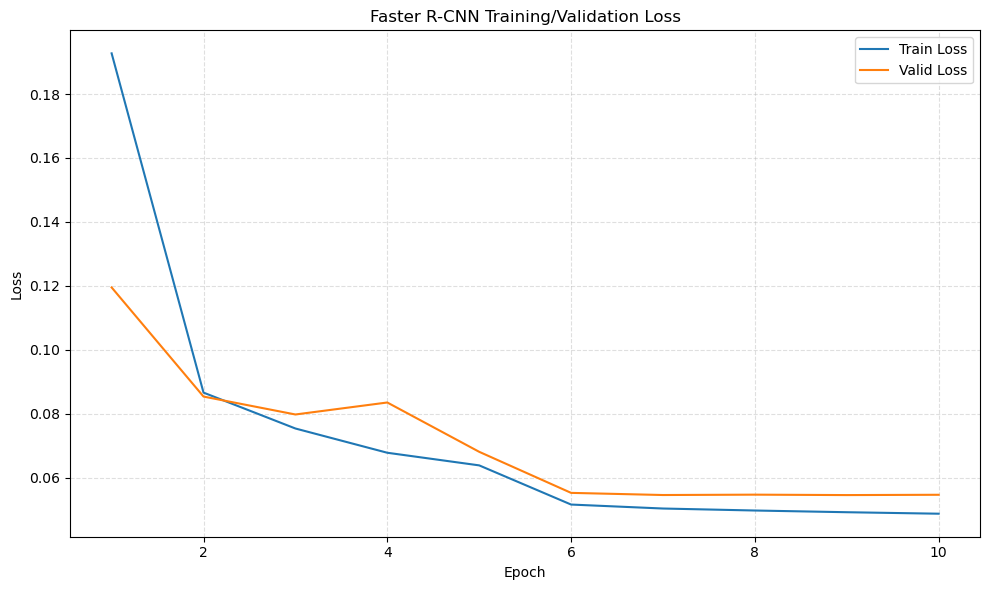

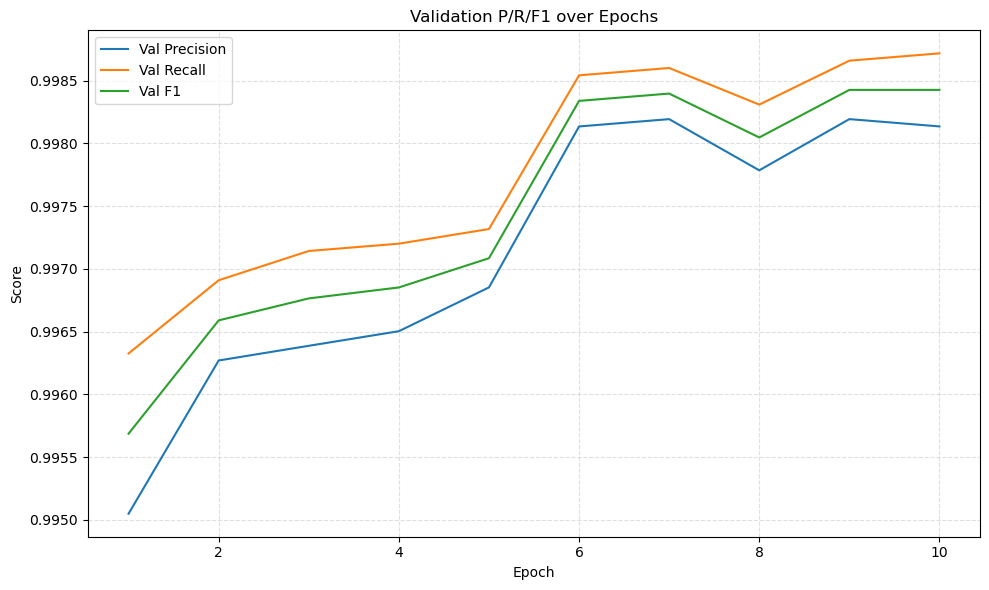

In [13]:
# =========================
# 실행
# =========================
if __name__ == "__main__":
    root = r"C:\Users\USER\DL_OCR\dataset"      # dataset 폴더
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_ds = CharDetDataset(root, "train")
    val_ds   = CharDetDataset(root, "valid")

    train_loader = DataLoader(train_ds, batch_size=6, shuffle=True,
                              num_workers=0, collate_fn=collate)
    val_loader   = DataLoader(val_ds, batch_size=6, shuffle=False,
                              num_workers=0, collate_fn=collate)

    model = build_model(num_classes=2).to(device)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1e-4)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    num_epochs = 10
    save_path = os.path.join(os.path.dirname(root), "char_det_frcnn_best.pth")
    best_f1 = -1

    # 로그 저장용
    history = {
        "train_loss": [],
        "val_loss":   [],
        "val_P":      [],
        "val_R":      [],
        "val_F1":     [],
    }

    for epoch in range(1, num_epochs+1):
        t0 = time.time()

        train_loss = train_one_epoch(model, train_loader, optimizer, device, max_norm=1.0)
        lr_scheduler.step()

        val_loss = eval_loss(model, val_loader, device)
        P,R,F1   = eval_pr(model, val_loader, device, iou_thr=0.8, score_thr=0.5)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_P"].append(P)
        history["val_R"].append(R)
        history["val_F1"].append(F1)

        dt = time.time() - t0
        print(f"[{epoch:02d}/{num_epochs}] "
              f"TrainLoss={train_loss:.4f}  ValLoss={val_loss:.4f}  "
              f"P={P:.3f} R={R:.3f} F1={F1:.3f}  ({dt:.1f}s)")

        if F1 > best_f1:
            best_f1 = F1
            torch.save({"model": model.state_dict(),
                        "epoch": epoch,
                        "best_f1": best_f1}, save_path)
            print(f"  → Best 갱신(F1={best_f1:.3f}): {save_path}")

    print("학습 완료. 최종 best F1:", best_f1)

    # 곡선 저장
    plot_curves(history, out_path=os.path.join(os.path.dirname(root), "frcnn_training_curves.png"))